# CNN을 활용한 특징 기반 모델


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch #기울기
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import torchvision #이미지관련 라이브러리
import torchvision.transforms as transforms #이미지변환
from torch.utils.data import Dataset, DataLoader, TensorDataset

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
train_dataset  = torchvision.datasets.FashionMNIST("data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_dataset  = torchvision.datasets.FashionMNIST("data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()])) 

100.0%
100.0%
100.0%
100.0%


In [16]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=128) #batch_size=100 데이터를 100씩 나눠서 본다.
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=128)

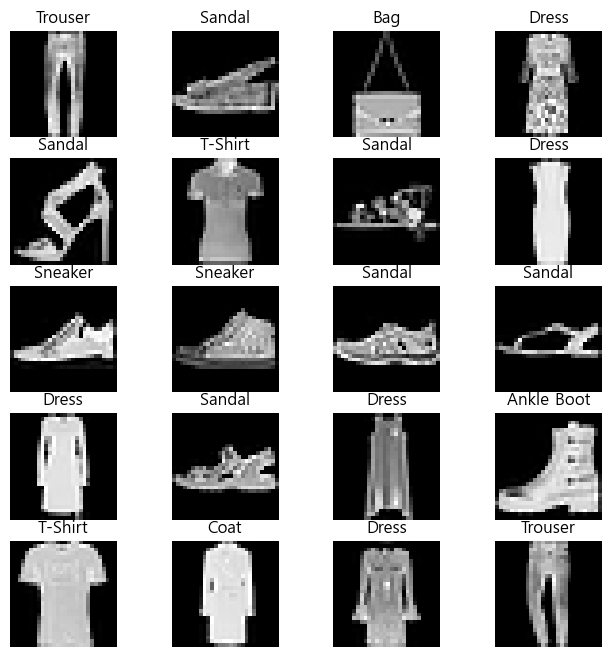

In [17]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [18]:
"""""
DNN(심층신경망)
은닉층 3개를 만드시오.(입력층 출력층 제외인가요?)
- 완전연결층으로 구성되어 있음
- 784(28x28)->256->128->10(출력)
- 과적합 방지를 위한 Dropout 적용
- 
"""""
#이미지 사이즈에러(고쳐야 돌아감)
#이미지 사이즈 에러 부분을 수정해서 실행 

class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN,self).__init__()
        self.fc1 = nn.Linear(in_features=784,out_features=256) # 입력측->첫번째 은닉층 보내는것 : 첫번째 은닉층
        self.drop = nn.Dropout2d(0.25) #Dropout2d : 신경끄고 집중해. 25%는 0으로 날리겠다.
        self.fc2 = nn.Linear(in_features=256,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=10) #두번째-> 출력층 보내는것.:출력층 (은닉층포함X)

    def forward(self,input_data): #학습시킬때 인풋데이터를 만들꺼야. 강제
        out = input_data.view(-1, 784) #784행으로 만들꺼야.
        out = F.relu(self.fc1(out)) #relu 활성화함수 : 중요한 기울기만 보겠다! :시그모이드보다 렐루많이사용함.
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [19]:
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model) #출력층 포함해서 3개층이다.

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [25]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(images.size(0), 1, 28, 28)) #Variable 자동미분
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
    
        if not (count % 50):    
            total = 0
            correct = 0        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)            
                test = Variable(images.view(images.size(0), 1, 28, 28))            
                outputs = model(test)            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.48858869075775146, Accuracy: 85.11000061035156%
Iteration: 1000, Loss: 0.3139582574367523, Accuracy: 85.86000061035156%
Iteration: 1500, Loss: 0.4302070736885071, Accuracy: 84.26000213623047%
Iteration: 2000, Loss: 0.21989288926124573, Accuracy: 86.19999694824219%


결과 : Loss 값이 낮아지고 Accuracy(성능) 높아진다.

In [26]:
class FashionCNN(nn.Module):    
    def __init__(self):
        super(FashionCNN, self).__init__()        
        #특징 추출
        # 28x28
        #1*28*28 ->I:32*24*24
        self.layer1 = nn.Sequential( #in_channels=1 : 그레이스케일로 사용하겠다 
            # 왜 출력이 32인가?->특징 맵의 수를 32로 설정한것 : Conv2d의 Output이랑 관련 없음
            # 아웃풋: 1*28*28 -> 특징맵기준 32*28*28
            #(입력사이즈 +(2 X 패딩 - 커널 사이즈)/stride)+1
            #28 +(2-3)+1 = 27 -1 1 = 28
            #이미지를 커널로 cnn(특징)돌렸을때 아웃풋이 28이다.
            #32인이유는 예전에 돌렸을때 성능이 잘나왔던 숫자이다. 위 256처럼.
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),#배치사이즈32 : 채널별로 하는것임 , 주의! [0,1]
            nn.ReLU(),#활성화함수 : 0미만 다 없애라.
            nn.MaxPool2d(kernel_size=2, stride=2) #숫자를 줄이는것은 MaxPool2d 에서 함
            # 32*28*2->32*14*14
        )
        #32채널-> 64채널
        #I:32*14*14 -> 64*14*14 
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), #64*3*1
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        #I:64*14*14-> 64*7*7 ->128*3*3
        #특징맵사이즈말고 채널에 신경써라 
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        #분류 계층   
        self.drop = nn.Dropout2d(0.25)     
        self.fc1 = nn.Linear(in_features=128*3*3, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=10)
        
    def forward(self, x):
        #CNN
        x = self.layer1(x) #32*14*14
        x = self.layer2(x) #64*7*7
        x = self.layer3(x) #128*3*3

        #분류 : 특징을 추출해서 독립변이로 내가 넣어줄께
        # 평탄화, 펼치다
        x = x.view(x.size(0), -1) #특징이 1152개?

        x = F.relu(self.fc1(x)) #512
        x = self.drop(x)
        x = F.relu(self.fc2(x)) #256
        x = self.fc3(x) #10, 여긴 왜 relu가 없나?
              
        return x

In [27]:
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc

In [28]:

def train_model(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
#-----------------------중요
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images) #에러발생. 사이즈가 안맞아서
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            #loss값 측정
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            #loss값 측정
            if batch_idx % 100 == 0:
                print(
                    f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}], "
                    f"Loss: {loss.item():.4f}"
                )
#-----------------------중요
        train_accuracy = 100 * correct_train / total_train
        test_accuracy = evaluate_model(model, test_loader)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        scheduler.step()

        print(
            f"Epoch [{epoch+1}/{num_epochs}], "
            f"Train Accuracy: {train_accuracy:.2f}%, "
            f"Test Accuracy: {test_accuracy:.2f}%"
        )

    return train_losses, train_accuracies, test_accuracies #로스값, 정확도, 테스트 필수





In [29]:
def evaluate_model(model, test_loader):
    """
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    model.train()
    return 100 * correct / total

In [30]:
#실행하면됨
cnn_model = FashionCNN()
cnn_model.to(device)
train_model(cnn_model, train_loader, test_loader)
 

Epoch [1/10], Batch [0], Loss: 2.3275
Epoch [1/10], Batch [100], Loss: 0.3320
Epoch [1/10], Batch [200], Loss: 0.3968
Epoch [1/10], Batch [300], Loss: 0.3312
Epoch [1/10], Batch [400], Loss: 0.3370
Epoch [1/10], Train Accuracy: 84.93%, Test Accuracy: 87.62%
Epoch [2/10], Batch [0], Loss: 0.2233
Epoch [2/10], Batch [100], Loss: 0.2164
Epoch [2/10], Batch [200], Loss: 0.2185
Epoch [2/10], Batch [300], Loss: 0.2233
Epoch [2/10], Batch [400], Loss: 0.2746
Epoch [2/10], Train Accuracy: 90.31%, Test Accuracy: 88.76%
Epoch [3/10], Batch [0], Loss: 0.1688
Epoch [3/10], Batch [100], Loss: 0.1526
Epoch [3/10], Batch [200], Loss: 0.2196
Epoch [3/10], Batch [300], Loss: 0.1770
Epoch [3/10], Batch [400], Loss: 0.2232
Epoch [3/10], Train Accuracy: 91.91%, Test Accuracy: 89.44%
Epoch [4/10], Batch [0], Loss: 0.1202
Epoch [4/10], Batch [100], Loss: 0.1553
Epoch [4/10], Batch [200], Loss: 0.1125
Epoch [4/10], Batch [300], Loss: 0.1671
Epoch [4/10], Batch [400], Loss: 0.1333
Epoch [4/10], Train Accuracy

([0.4121854334815479,
  0.26392849047046735,
  0.22083202139464522,
  0.19379747660556582,
  0.16556443845920726,
  0.12484900278847481,
  0.10012106799971321,
  0.08545446872059852,
  0.07484538032651455,
  0.0657533632555623],
 [84.93333333333334,
  90.305,
  91.91333333333333,
  92.815,
  93.91,
  95.385,
  96.25333333333333,
  96.77,
  97.235,
  97.55],
 [87.62, 88.76, 89.44, 90.5, 90.05, 90.8, 90.0, 90.16, 90.49, 90.38])

# 전이학습

In [38]:
import os
import time
import copy
import glob
#import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [39]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기: chap05/data/catndog.zip 파일 선택

ModuleNotFoundError: No module named 'google.colab'

In [46]:
!unzip catanddog.zip -d catanddog/    #catanddog 폴더 만들어 압축 풀기

'unzip'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [47]:
data_path = 'data/catanddog/train/'
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    #num_workers=8, #intel 에서만 됨. 삭제하기
    shuffle=True
)

print(len(train_dataset))

385


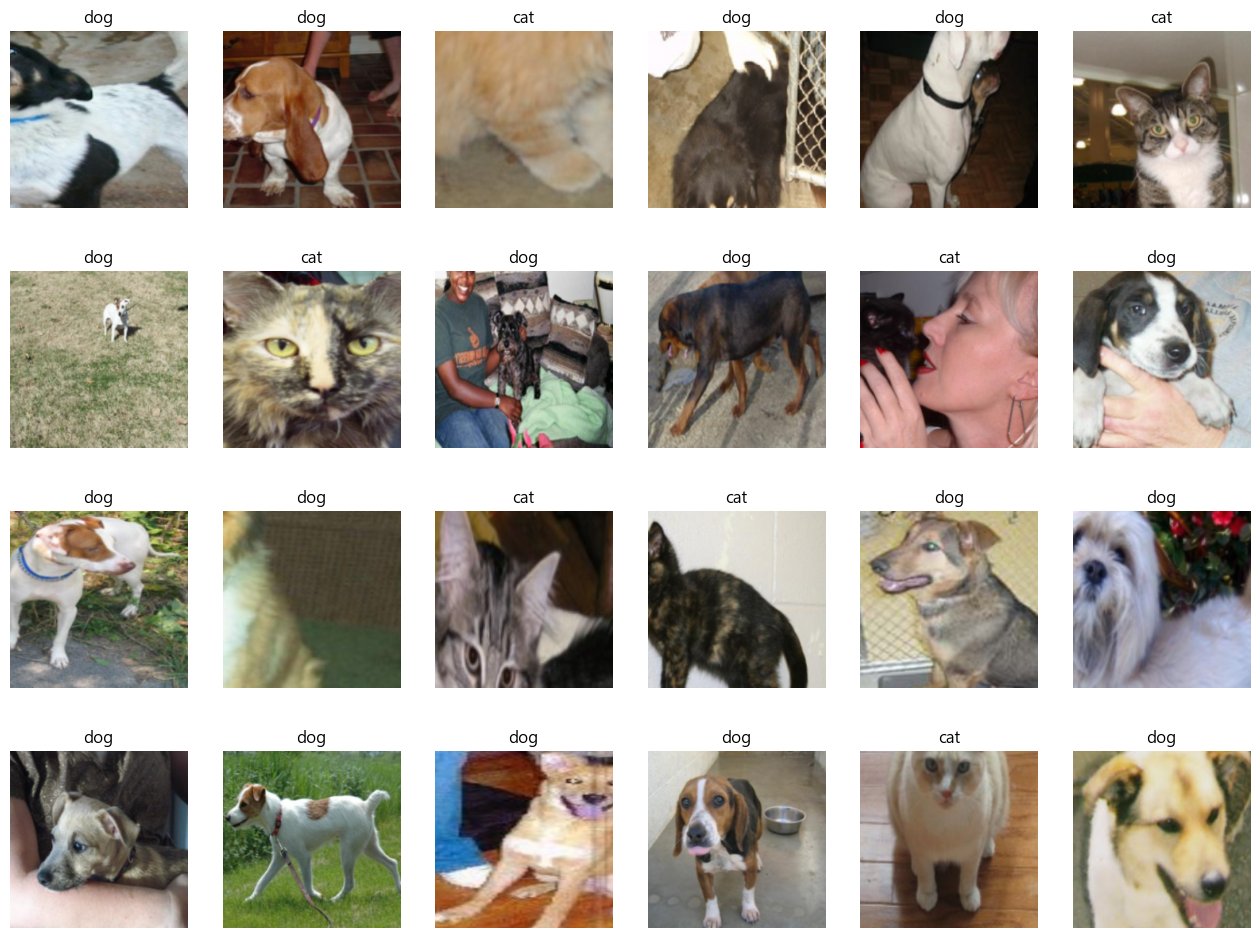

In [36]:
import numpy as np
samples, labels = next(iter(train_loader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [ ]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1) #resnet18 은닉층이 18
#설마, 분류 레이어만 수정 가능할까?

In [43]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(resnet18)

In [ ]:
resnet18.fc = nn.Linear(512, 2) #분류계층을 512를 2(개,고양이) 바꾼것

In [45]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[-0.0371,  0.0406, -0.0319,  ..., -0.0055,  0.0141,  0.0084],
        [ 0.0312, -0.0175,  0.0317,  ..., -0.0077, -0.0031, -0.0317]])
fc.bias tensor([-0.0170, -0.0424])


In [11]:
model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

In [13]:
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
            
optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss: 0.6379 Acc: 0.6182

Epoch 1/12
----------
Loss: 0.4221 Acc: 0.8208

Epoch 2/12
----------
Loss: 0.3172 Acc: 0.9013

Epoch 3/12
----------
Loss: 0.3590 Acc: 0.8519

Epoch 4/12
----------
Loss: 0.2578 Acc: 0.9013

Epoch 5/12
----------
Loss: 0.2505 Acc: 0.9117

Epoch 6/12
----------
Loss: 0.2591 Acc: 0.8961

Epoch 7/12
----------
Loss: 0.2232 Acc: 0.9143

Epoch 8/12
----------
Loss: 0.2007 Acc: 0.9117

Epoch 9/12
----------
Loss: 0.1841 Acc: 0.9299

Epoch 10/12
----------
Loss: 0.1875 Acc: 0.9403

Epoch 11/12
----------
Loss: 0.2198 Acc: 0.9091

Epoch 12/12
----------
Loss: 0.2169 Acc: 0.9039

Training complete in 0m 36s
Best Acc: 0.940260


In [16]:
test_path = 'catanddog/validation/'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [17]:
def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)           
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history

In [18]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['catanddog/00.pth', 'catanddog/01.pth', 'catanddog/02.pth', 'catanddog/03.pth', 'catanddog/04.pth', 'catanddog/05.pth', 'catanddog/06.pth', 'catanddog/07.pth', 'catanddog/08.pth', 'catanddog/09.pth', 'catanddog/10.pth', 'catanddog/11.pth', 'catanddog/12.pth']
Loading model catanddog/00.pth
Acc: 0.8469

Loading model catanddog/01.pth
Acc: 0.8878

Loading model catanddog/02.pth
Acc: 0.9286

Loading model catanddog/03.pth
Acc: 0.9286

Loading model catanddog/04.pth
Acc: 0.9388

Loading model catanddog/05.pth
Acc: 0.9286

Loading model catanddog/06.pth
Acc: 0.9388

Loading model catanddog/07.pth
Acc: 0.9184

Loading model catanddog/08.pth
Acc: 0.9286

Loading model catanddog/09.pth
Acc: 0.9184

Loading model catanddog/10.pth
Acc: 0.9286

Loading model catanddog/11.pth
Acc: 0.9184

Loading model catanddog/12.pth
Acc: 0.9184

Validation complete in 0m 8s
Best Acc: 0.938776


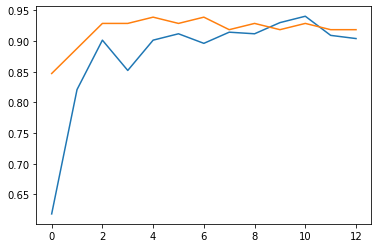

In [19]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

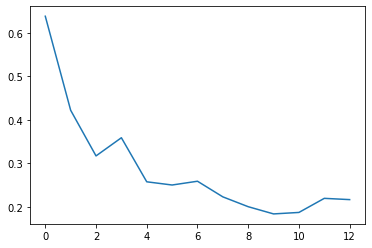

In [20]:
plt.plot(train_loss_hist)
plt.show()

In [21]:
def im_convert(tensor):  
    image=tensor.clone().detach().numpy()  
    image=image.transpose(1,2,0)  
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))  
    image=image.clip(0,1)  
    return image  

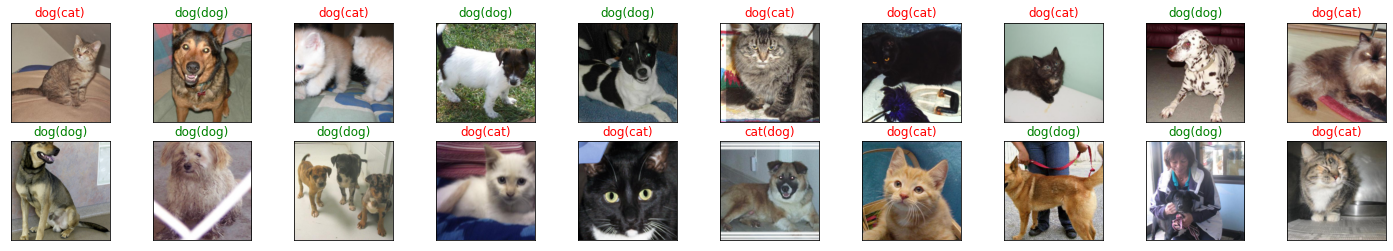

<Figure size 432x288 with 0 Axes>

In [22]:
classes = {0:'cat', 1:'dog'}

dataiter=iter(test_loader)  
images,labels=dataiter.next()  
output=model(images)  
_,preds=torch.max(output,1) 

fig=plt.figure(figsize=(25,4))  
for idx in np.arange(20):  
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])  
    plt.imshow(im_convert(images[idx]))  
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))  
plt.show()  
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [ ]:
# 5.4.1 특성 맵 시각화

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x)

In [5]:
model=XAI()
model.cpu() #모델에 입력되는 이미지를 넘파이로 받아오는 부분때문에 CPU를 사용하도록 지정하였습니다
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [7]:
class LayerActivations:
    features=[]
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
   
    def hook_fn(self, module, input, output):
        output = output
        #self.features = output.to(device).detach().numpy()
        self.features = output.detach().numpy()
    def remove(self): 
        self.hook.remove()

Saving cat.jpg to cat.jpg
torch.Size([1, 3, 100, 100])


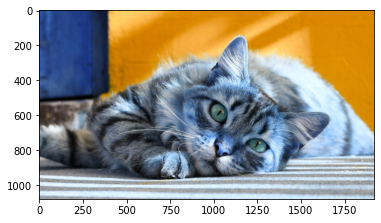

In [8]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # chap05/data/cat.jpg 데이터 불러오기

img=cv2.imread("cat.jpg")   
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)

print(img.shape)

In [9]:
result = LayerActivations(model.features, 0)
model(img)
activations = result.features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


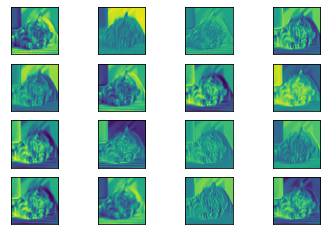

<Figure size 864x576 with 0 Axes>

In [10]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [11]:
result = LayerActivations(model.features, 20)

model(img)
activations = result.features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


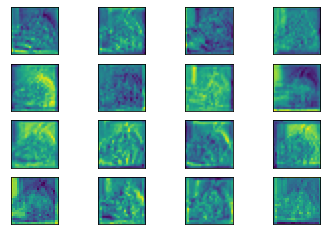

<Figure size 864x576 with 0 Axes>

In [12]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [13]:
result = LayerActivations(model.features, 40)

model(img)
activations = result.features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


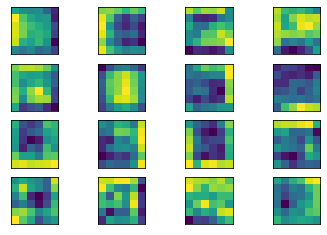

<Figure size 864x576 with 0 Axes>

In [14]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()